# Explore correlation with e.g. ENSO to include as covariate 

In [12]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, 
# statsmodels, seaborn

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4
import cftime

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


In [2]:
from scipy import stats
import seaborn as sns

import corner # installed in myenv

from statsmodels.nonparametric.smoothers_lowess import lowess


#import dist_cov # env = myenv where i installed dist_cov

sys.path.append('../dist_cov/dist_cov/')
import distributions as distributions
import sample as sample
import utils as utils 

In [3]:
start_message() 

flags: {'models': 'ISIMIP3a', 'experiment': 'counterclim', 'metric': 'WBGT', 'method': 'calculate', 'time_method': None, 'chunk_version': 2}
var: None
VARs: ['tasmax', 'huss', 'ps']
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/

In [4]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')
flags['models'] = 'ISIMIP3a'
GCM=datasets[0]  # 'GSWP3-W5E5'

## Open covariates

In [6]:
def apply_lowess(y, x=None, ntime=31):
    ''' y should be an xarray DataArray,
        x is used when provided, else falling back to standard indices
    '''
    # Squeeze (in case there is a dimension of size 1 that we don't need)
    y = y.squeeze()
    
    # Create a copy, plug in smoothed data later
    final = y.copy(deep=True)
    
    if x is None:
        x = np.arange(y.size)
    
    if not isinstance(y, np.ndarray):
        y = y.values

    # Apply LOWESS smoothing
    result = lowess(y, x, frac=ntime/y.size)
    
    x_smooth, y_smooth = result[:, 0], result[:, 1]
    
    # Ensure the smoothed result has the same length as the original data
    y_smooth_full = np.interp(x, x_smooth, y_smooth)

    # Assign the smoothed values back to the xarray DataArray
    final[:] = y_smooth_full[:]

    return final

<AxesSubplot:xlabel='year'>

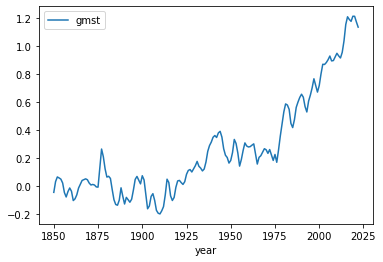

In [85]:
# GMST 

df_gmst_obs_annual = pd.read_csv(os.path.join('../../data/gmst/gmst-obs/forster2023/annual_averages.csv')).rename(
    columns={'timebound_lower':'year'}).set_index('year')[['gmst']]
gmst_smo = pd.DataFrame(apply_lowess(df_gmst_obs_annual, df_gmst_obs_annual.index, ntime=4))
gmst_smo.plot()

In [86]:
gmst_smo = gmst_smo.to_xarray().rename({'year':'time'})['gmst']
times = np.datetime64('1850-01') + np.arange(len(gmst_smo), dtype='timedelta64[Y]')
gmst_smo['time']=times
gmst_smo

<xarray.DataArray 'gmst' (time: 173)>
array([-0.04351896,  0.03294702,  0.06647958,  0.0593622 ,  0.05076782,
        0.02331276, -0.04499339, -0.07641593, -0.03813725, -0.01227721,
       -0.03582003, -0.10207987, -0.08964705, -0.06109205, -0.01265328,
        0.01377957,  0.04152033,  0.04722616,  0.0529354 ,  0.04640833,
        0.02291455,  0.00917495,  0.01293008,  0.00901525, -0.00448441,
       -0.00631412,  0.13047102,  0.2655795 ,  0.2107762 ,  0.12378672,
        0.06565776,  0.07114718,  0.05589927, -0.02288061, -0.09592656,
       -0.1301045 , -0.13521052, -0.09875141, -0.01107363, -0.07180081,
       -0.12651164, -0.07932126, -0.09589848, -0.11389068, -0.09214018,
       -0.0260562 ,  0.04898296,  0.07027636,  0.04385272,  0.0170613 ,
        0.07522497,  0.0456877 , -0.05781485, -0.16054316, -0.14053257,
       -0.07226498, -0.05282446, -0.10054545, -0.17161284, -0.19239304,
       -0.19725921, -0.17521295, -0.14545854, -0.0605522 ,  0.05049729,
        0.02680613, -0.06835044, -0.10151802, -0.07988344, -0.00703258,
        0.03825716,  0.04172598,  0.0261434 ,  0.01303936,  0.03252295,
        0.08523215,  0.11278066,  0.11926475,  0.10186275,  0.12436275,
        0.14686274,  0.17735791,  0.14258187,  0.12942816,  0.10947709,
        0.12323458,  0.17313843,  0.2490154 ,  0.29031739,  0.3151021 ,
        0.34943117,  0.36200251,  0.34798224,  0.38047581,  0.39185812,
        0.35075761,  0.26790737,  0.22155192,  0.20528957,  0.16537803,
        0.1845173 ,  0.24021673,  0.33402788,  0.30522682,  0.23748224,
        0.14385433,  0.1916666 ,  0.25571451,  0.30928076,  0.28736941,
        0.28025038,  0.28287615,  0.29327215,  0.30250487,  0.23227237,
        0.15847422,  0.20620986,  0.21801652,  0.24347115,  0.26785058,
        0.26038913,  0.23484048,  0.26186274,  0.22311274,  0.18436274,
        0.22675655,  0.17100188,  0.25858414,  0.35817061,  0.44571556,
        0.53074874,  0.58737469,  0.57947929,  0.54864472,  0.44842133,
        0.41864765,  0.47563724,  0.56275269,  0.60079765,  0.63354646,
        0.65673672,  0.63539448,  0.56807474,  0.52994596,  0.60793279,
        0.6507922 ,  0.70252574,  0.76686274,  0.71936274,  0.67186274,
        0.71811229,  0.80081821,  0.87034028,  0.86872215,  0.88251116,
        0.90274099,  0.92908782,  0.89435209,  0.89675307,  0.92327596,
        0.9486523 ,  0.92993945,  0.91505466,  0.95545219,  1.03709981,
        1.15407241,  1.20911491,  1.18986125,  1.17642816,  1.21288951,
        1.21256394,  1.17232278,  1.13519301])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1851-01-01 ... 2022-01-01

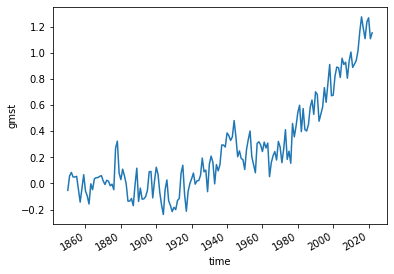

In [134]:
gmst= df_gmst_obs_annual.to_xarray().rename({'year':'time'})['gmst']
times = np.datetime64('1850-01') + np.arange(len(gmst_smo), dtype='timedelta64[Y]')
gmst['time']=times
gmst.plot()

In [40]:
# NINO 3.4 
# https://climexp.knmi.nl/selectindex.cgi?id=ab69f3855272f534f68348624570859f
# https://climexp.knmi.nl/getindices.cgi?WMO=NCDCData/ersst_nino3.4a_rel&STATION=NINO3.4_rel&TYPE=i&id=ab69f3855272f534f68348624570859f

# should I smooth this ?? 

nino = xr.open_dataarray(os.path.join('../../data/mocv/iersst_nino3.4a_rel.nc'),decode_times=False )

# time axis 
# Define the start date
times = np.datetime64('1854-01') + np.arange(len(nino), dtype='timedelta64[M]')
nino['time']=times
nino = nino.sel(time=slice('1854-01-01','2024-04-01'))
nino

<xarray.DataArray 'Nino3.4r' (time: 2044)>
array([-0.372089, -0.412033, -0.168306, ...,  0.749947,  0.475783,  0.121691],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2024-04-01
Attributes:
    long_name:  ERSST v5 relative Nino3.4 index
    units:      K

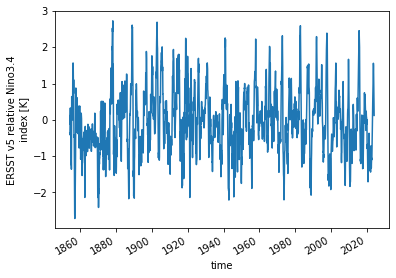

In [41]:
nino.plot()

In [52]:
# AMV
amv = xr.open_dataarray(os.path.join('../../data/mocv/iamo_hadsst.nc'), decode_times=False )

# time axis 
# Define the start date
times = np.datetime64('1850-01') + np.arange(len(amv), dtype='timedelta64[M]')
amv['time']=times
amv = amv.sel(time=slice('1850-01-01','2024-03-01'))
amv

<xarray.DataArray 'AMO' (time: 2091)>
array([ 0.232434,  0.05592 , -0.002497, ...,  0.076343,  0.195665,  0.236097],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-03-01
Attributes:
    long_name:  Atlantic Multidecadal Variability index
    units:      K

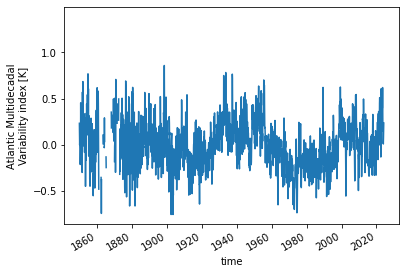

In [53]:
amv.plot()

In [54]:
amv_er = xr.open_dataarray(os.path.join('../../data/mocv/iamo_ersst.nc'), decode_times=False )

# time axis 
times = np.datetime64('1880-01') + np.arange(len(amv_er), dtype='timedelta64[M]')
amv_er['time']=times
amv_er = amv_er.sel(time=slice('1880-01-01','2023-11-01'))
amv_er

<xarray.DataArray 'AMO' (time: 1727)>
array([ 0.273044,  0.218995,  0.172513, ..., -0.019322,  0.155192,  0.027268],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-11-01
Attributes:
    long_name:  SST
    units:      C

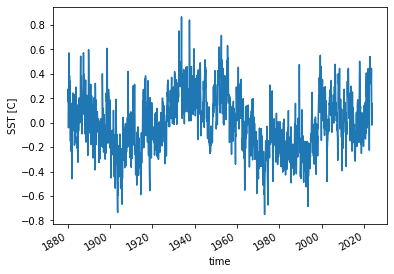

In [55]:
amv_er.plot()

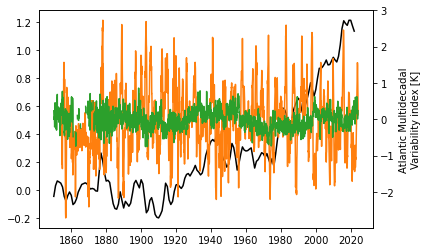

In [70]:
# fig, ax = plt.subplots()

# ax2 = ax.twinx()

# nino.plot(ax=ax2, c='C1')
# amv.plot(ax=ax2, c='C2')
# #amv_er.plot(ax=ax2, c='C3')

# ax.plot(np.datetime64('1850-01')+np.arange(len(gmst_smo), dtype='timedelta64[Y]'), gmst_smo, c='k')

## Correlation and partial correlation: open WBGT


In [71]:
variable='wbgt'
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!
dir1=os.path.join(scratchdirs, dirname, 'WBGT', flags['models'], 'obsclim', GCM ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)

with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    lat, lon = 28,77
    da_delhi = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()
    lat, lon = 22,88
    da_calcutta = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()

In [105]:
print(xr.corr(da_delhi, gmst_smo).values)
print(xr.corr(da_calcutta, gmst_smo).values)

0.1716394363419774
0.48579585200652936


In [104]:
print(xr.corr(da_delhi, nino).values)
print(xr.corr(da_calcutta, nino).values)
# weak correlation !! month to month 

-0.026284574627485794
-0.016762362320323396


In [102]:
print(xr.corr(da_delhi, amv).values)
print(xr.corr(da_calcutta, amv).values)

-0.029504341169306912
-0.033351176259901374


In [101]:
print(xr.corr(da_delhi,nino.resample(time='Y').mean()).values)
print(xr.corr(da_calcutta,nino.resample(time='Y').mean()).values)

-0.031299682831590646
-0.13936407350744281


In [121]:

import statsmodels.api as sm

def partial_correlation(xarray_data, control_vars):
    # Assuming xarray_data is a DataArray or Dataset with time as one of the dimensions
    #data = xarray_data.to_dataframe().dropna()
    
    # Construct the regression model for control variables
    X = sm.add_constant(data[control_vars])
    
    partial_corrs = {}
    
    for var in data.columns:
        if var not in control_vars:
            y = data[var]
            
            # Regression model for var on control variables
            model_y = sm.OLS(y, X).fit()
            residual_y = model_y.resid
            
            for other_var in data.columns:
                if other_var != var and other_var not in control_vars:
                    z = data[other_var]
                    
                    # Regression model for other_var on control variables
                    model_z = sm.OLS(z, X).fit()
                    residual_z = model_z.resid
                    
                    # Compute correlation between the residuals
                    corr = np.corrcoef(residual_y, residual_z)[0, 1]
                    partial_corrs[(var, other_var)] = corr
    
    return partial_corrs




In [108]:
# Example data creation (replace with actual xarray.DataArray or xarray.Dataset)
time = pd.date_range('2000-01-01', periods=100, freq='M')
data = xr.Dataset({
    'var1': ('time', np.random.rand(100)),
    'var2': ('time', np.random.rand(100)),
    'control_var': ('time', np.random.rand(100)),
}, coords={'time': time})

# Compute partial correlations controlling for 'control_var'
partial_corrs = partial_correlation(data, ['control_var'])
print(partial_corrs)

{('var1', 'var2'): 0.053595061247012535, ('var2', 'var1'): 0.05359506124701253}


In [137]:
data = xr.merge([da_delhi.drop(['lat','lon']), gmst, nino],join='left').to_dataframe().ffill() # not sure best method?? 
data

,wbgt,gmst,Nino3.4r
time,,,
1901-01-01,16.663191,0.069363,0.544047
1901-01-02,16.832773,0.069363,0.544047
1901-01-03,16.748079,0.069363,0.544047
1901-01-04,15.503975,0.069363,0.544047
1901-01-05,18.544516,0.069363,0.544047
...,...,...,...
2019-12-27,14.542236,1.236863,0.095328
2019-12-28,12.874272,1.236863,0.095328
2019-12-29,13.003847,1.236863,0.095328


In [138]:
partial_correlation(data, ['Nino3.4r'])

{('wbgt', 'gmst'): 0.05105434179717635, ('gmst', 'wbgt'): 0.05105434179717635}

In [139]:
data.corr()

,wbgt,gmst,Nino3.4r
wbgt,1.000000,0.052125,-0.019961
gmst,0.052125,1.000000,-0.058544
Nino3.4r,-0.019961,-0.058544,1.000000


In [149]:
data = xr.merge([
    da_delhi.drop(['lat','lon']).resample(time='M',label='left').mean().assign_coords(time=lambda t: t.time + pd.Timedelta('1D')), 
    gmst, 
    nino,
    amv
],join='left').to_dataframe().ffill() 

data.corr()

,wbgt,gmst,Nino3.4r,AMO
wbgt,1.000000,0.055322,-0.020867,-0.033258
gmst,0.055322,1.000000,-0.058066,0.051001
Nino3.4r,-0.020867,-0.058066,1.000000,-0.302733
AMO,-0.033258,0.051001,-0.302733,1.000000


In [150]:
data = xr.merge([
    da_delhi.drop(['lat','lon']).resample(time='Y',label='left').mean().assign_coords(time=lambda t: t.time + pd.Timedelta('1D')), 
    gmst, 
    nino.resample(time='Y',label='left').mean().assign_coords(time=lambda t: t.time + pd.Timedelta('1D')),
    amv.resample(time='Y',label='left').mean().assign_coords(time=lambda t: t.time + pd.Timedelta('1D')),
],join='left').to_dataframe()

data.corr()

,wbgt,gmst,Nino3.4r,AMO
wbgt,1.000000,0.444619,-0.120513,0.155021
gmst,0.444619,1.000000,-0.080992,0.065176
Nino3.4r,-0.120513,-0.080992,1.000000,-0.395448
AMO,0.155021,0.065176,-0.395448,1.000000


In [151]:
partial_correlation(data, ['Nino3.4r'])

# strong positive correlation at annual scales ! 0.43 

# weak relationship with modes of climate variability, it seems? at least enso and Nino

{('wbgt', 'gmst'): 0.4394945547300505,
 ('wbgt', 'AMO'): 0.11775032290517298,
 ('gmst', 'wbgt'): 0.4394945547300506,
 ('gmst', 'AMO'): 0.03620853147434781,
 ('AMO', 'wbgt'): 0.11775032290517298,
 ('AMO', 'gmst'): 0.03620853147434782}

In [153]:
partial_correlation(data, ['AMO'])


{('wbgt', 'gmst'): 0.4407692486152819,
 ('wbgt', 'Nino3.4r'): -0.06525406877752755,
 ('gmst', 'wbgt'): 0.44076924861528183,
 ('gmst', 'Nino3.4r'): -0.06024662429445997,
 ('Nino3.4r', 'wbgt'): -0.06525406877752755,
 ('Nino3.4r', 'gmst'): -0.06024662429445997}

In [152]:
partial_correlation(data, ['gmst'])

{('wbgt', 'Nino3.4r'): -0.09465145879806036,
 ('wbgt', 'AMO'): 0.14101602315729012,
 ('Nino3.4r', 'wbgt'): -0.09465145879806036,
 ('Nino3.4r', 'AMO'): -0.39228907825383036,
 ('AMO', 'wbgt'): 0.14101602315729012,
 ('AMO', 'Nino3.4r'): -0.39228907825383036}